In [26]:
import pandas as pd
import numpy as np
import spacy
import re
import string
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk
from spellchecker import SpellChecker
from textblob import TextBlob

In [2]:
filterwarnings(action='ignore')

In [3]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [4]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### Checking NaNs

In [7]:
# num of missing values

print('num of NaNs in the keywords: ', train_df.keyword.isna().sum())
print('num of NaNs in the locations: ', train_df.location.isna().sum())
print('num of NaNs in the text: ', train_df.text.isna().sum())

num of NaNs in the keywords:  61
num of NaNs in the locations:  2533
num of NaNs in the text:  0


In [8]:
for df in [train_df, test_df]:
    df['has_location'] = 1
    df.loc[(df['location'].isna()), 'has_location'] = 0

    df['has_keyword'] = 1
    df.loc[(df['keyword'].isna()), 'has_keyword'] = 0

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'target')]

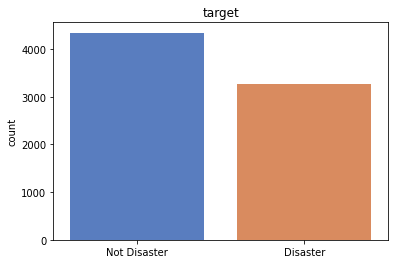

In [9]:
# target distribution

results = train_df.groupby('target', as_index=False)['id'].count()
g = sns.barplot(['Not Disaster', 'Disaster'], results['id'], palette='muted')
g.set(ylabel='count', title='target')

### Character distribution

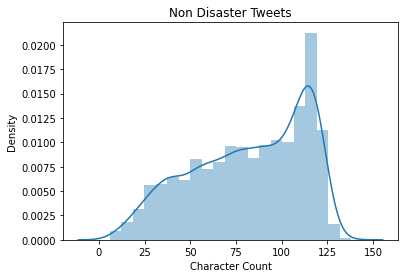

In [10]:
# non disasters

g = sns.distplot(train_df[train_df['target'] == 0]
                 ['text'].str.replace(' ', '').map(lambda x: len(x)))
g.set(title='Non Disaster Tweets', xlabel='Character Count')
plt.show()

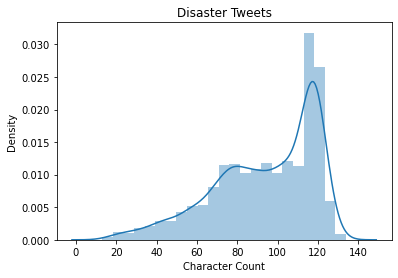

In [11]:
# non disasters

g = sns.distplot(train_df[train_df['target'] == 1]
                 ['text'].str.replace(' ', '').map(lambda x: len(x)))
g.set(title='Disaster Tweets', xlabel='Character Count')
plt.show()

### Word distribution

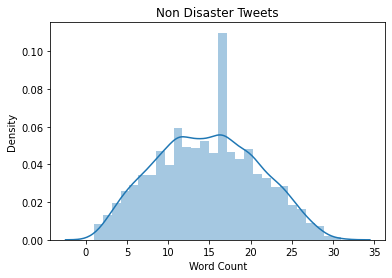

In [12]:
# non disasters

g = sns.distplot(train_df[train_df['target'] == 0]
                 ['text'].str.split().map(lambda x: len(x)))
g.set(title='Non Disaster Tweets', xlabel='Word Count')
plt.show()

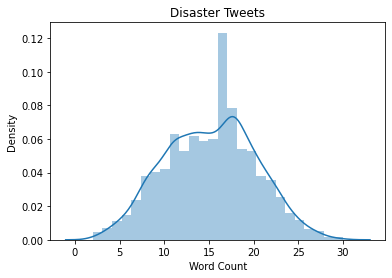

In [13]:
# disasters

g = sns.distplot(train_df[train_df['target'] == 1]
                 ['text'].str.split().map(lambda x: len(x)))
g.set(title='Disaster Tweets', xlabel='Word Count')
plt.show()

## Spell correction

In [53]:
def spell_corrector(text):
    corrected = str(TextBlob(text).correct())
    return corrected

## Removing stop words

In [36]:
def stopword_remover(text):
    sw_nltk = set(stopwords.words('english'))
    sw_clean = [word for word in text if word not in sw_nltk]
    return sw_clean

## Remove URL and HTML tags and numbers

In [37]:
def url_remover(text):
    # urls
    text = re.sub(
        r'https?://\S+|www\.\S+', '', text)

    # html tags
    text = re.sub(r'<.*?>', '', text)

    # numbers
    text = re.sub(r'\d+', '', text)

    return text

## Remove punctuation marks

In [38]:
def punctuation_remover(text):
    import string

    punc_clean = [words for words in text if words not in string.punctuation]
    return ''.join(punc_clean)

## Remove Emojies

In [39]:
def emoji_remover(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

## Tokenization

In [40]:
def tokenizer(text):
    tokens = word_tokenize(text)
    return tokens

## Lemmatization

In [41]:
def lemmatizer(text):
    lem = [WordNetLemmatizer().lemmatize(word) for word in text]
    return lem

## Converting array to text

In [42]:
def token_to_text(token):
    return ' '.join(token)

## Text cleaner pipeline

In [54]:
def pipline(data):
    data['clean_text'] = data['text'].apply(lambda x: str.lower(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: url_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: emoji_remover(x))
    data['clean_text'] = data['clean_text'].apply(
        lambda x: punctuation_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: spell_corrector(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: tokenizer(x))
    data['clean_text'] = data['clean_text'].apply(
        lambda x: stopword_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: lemmatizer(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: token_to_text(x))

In [55]:
pipline(train_df)
pipline(test_df)

In [56]:
train_df

,id,keyword,location,text,target,has_location,has_keyword,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,0,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,forest fire near la range ask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,0,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,0,got sent photo ruby alaska smoke wildfire hour...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,two giant crank holding bridge collapse nearby...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0,0,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0,0,tuck volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,police investigation bike collided car little ...


In [70]:
pd.Series(' '.join(train_df['clean_text']).split()).value_counts()[:20]

fire         360
like         358
amp          300
u            281
get          279
via          229
new          226
news         222
one          208
people       201
go           194
dont         191
time         185
video        176
emergency    159
disaster     156
year         156
day          155
body         152
home         146
dtype: int64

## Word cloud

### Disaster

In [58]:
def wordcloud_plot(df, target):
    words = []
    for x in df[df['target'] == target]['text'].str.split():
        for i in x:
            words.append(i)

    # plotting
    plt.figure(figsize=(12, 8))
    word_cloud = WordCloud(
        background_color='white',
        max_font_size=80
    ).generate(" ".join(words[:50]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

Disaster


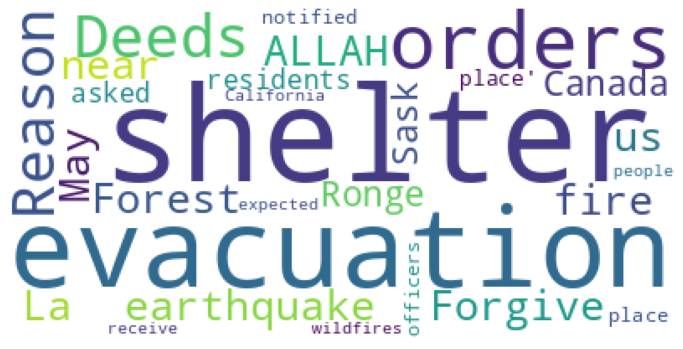

In [59]:
print('Disaster')
wordcloud_plot(train_df, 1)

### Not disaster

Not A Disaster


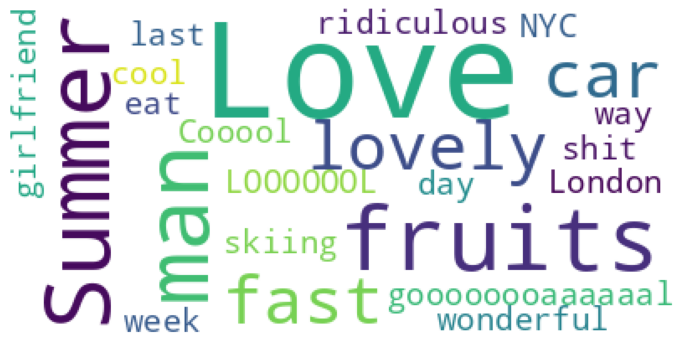

In [60]:
print('Not A Disaster')
wordcloud_plot(train_df, 0)

## Train and test split

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

In [62]:
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'].to_numpy(
), train_df['target'].to_numpy(), test_size=0.2, random_state=42)

## Bag of words

In [63]:
tf_transformer = TfidfVectorizer().fit(X_train)
train_features = tf_transformer.transform(X_train)

val_features = tf_transformer.transform(X_val)

In [64]:
nv = MultinomialNB()
rf = RandomForestClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lgbm', lgbm), ('rf', rf), ('nv', nv), ('xgb', xgb)], voting='hard')

for clf in (nv, rf, lgbm, xgb, voting_clf):
    clf.fit(train_features, y_train)
    print(clf.__class__.__name__, accuracy_score(
        y_val, clf.predict(val_features)))

MultinomialNB 0.7925147734734077
RandomForestClassifier 0.7734734077478661
LGBMClassifier 0.7820091923834537
[20:24:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.7616546290216678
[20:24:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 0.7859487852921865


In [71]:
test = test_df['clean_text'].to_numpy()

In [72]:
test_features = tf_transformer.transform(test)

In [73]:
y_pred = voting_clf.predict(test_features)

In [74]:
submission = pd.DataFrame(columns=['id', 'target'])
submission['id'] = test_df['id']
submission['target'] = y_pred

submission.to_csv('sub.csv', index=False)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
